## Simple Multiple Pendulums
### Introduction


While totally working on homework and not falling down a youtube rabbit hole. I came across [this video](https://youtu.be/mZ1hF_-cubA?t=163) they use glow in the dark paint and a light attached to atriple pendiulm to show the chaotic and seeminly unpredicable nature of a triple pendlum.
So why not try and tame this chaotic beast.

 The double and triple pendilum is a common classical mechanics problem used to help teach the equations of motions.

- Overview of theoretical concepts relevant to the project. Spells out hypothesis or scientific questions being addressed with the investigation.

![Triple Pendilum ](./media/M.png 'how cool')


### Kane's method
##### Why?
- This is a way to calculate euations of motion by using quasivelocities. No need to calculate differentiate scalar energy functions for KE and PE. 
- Kane's method just requires differnention for the velovities and acceleration, but we will just let a python library handle that.

For the automation of these equations, we start with a reference frame centered around the inital pivot point then attacch a point to that frame of length $l$ we then assign the forces that will be applied to this mass, then derive the kenismatic equations for this point finally we make a new rerence frame for this point and attach then next mass to it

### Potential Energy
$n=1 $ <br>
$V = −m_1gy_1$<br>
$V =−m_1gl_1cos\theta_1$


$n=2$ <br>
$V = −m_1gy_1−m_2gy_2$
$V =−m_1gl_1cos\theta_1−m_2g(l_1cos(\theta_1)+l2cos(\theta_2))$

$n=3$ <br>
$V = −m_1gy_1−m_2gy_2−m_3gy_3$
$V =−m_1gl_1cos\theta_1−m_2g(l_1cos(\theta_1)+l2cos(\theta_2))−m_3g(l_1cos(\theta_1)+l2cos(\theta_2)+l3cos(\theta_3))$


$V= \sum_{k=0}^n m_k l_k \sum_{i=0}^k cos(\theta_i)$

### Kinetic Energy
$n=1 $<br>
$T = \frac{1}{2} m_1v_1^2 $<br>
$T = \frac{1}{2} m_1l_1^2\dot\theta_1^2 $

$n=2$<br>
$T = \frac{1}{2} m_1v_1^2 +\frac{1}{2} m_2v_2^2$<br>
$T = \frac{1}{2} m_1l_1^2\dot\theta_1^2 +\frac{1}{2} m_2(l_1^2\dot\theta_1^2+l_2^2\dot\theta_2^2+2l_1l_2\dot\theta_1
\dot\theta_2cos(\theta_2-\theta_1)    $

$n=3$<br>
$T = \frac{1}{2} m_1v_1^2 +\frac{1}{2} m_2v_2^2+\frac{1}{2} m_3v_3^2$<br>
$T = \frac{1}{2} m_1l_1^2\dot\theta_1^2
+\frac{1}{2} m_2(l_1^2\dot\theta_1^2+l_2^2\dot\theta_2^2+2l_1l_2\dot\theta_1\dot\theta_2cos(\theta_2-\theta_1))
+\frac{1}{2} m_3(l_1^2\dot\theta_1^2+l_2^2\dot\theta_2^2+l_3^2\dot\theta_3^2+
2l_1l_2\dot\theta_1\dot\theta_2cos(\theta_2-\theta_1)+
2l_2l_3\dot\theta_2\dot\theta_3cos(\theta_3-\theta_2))    $

You can easily see how the once we convert the  kinetic and potential energy in to terms of generalized codinates the kenitic energy equations can easily get out of hand
<br>
$KE = \sum_{k=0}^n \frac{1}{2} m_k \sum_{i,j}^k   l_jl_i\dot\theta_j\dot\theta_icos(\theta_i-\theta_j)) $

In [14]:
from sympy import Dummy, lambdify
from scipy.integrate import odeint
import numpy as np
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib import pyplot as plt
from sympy.physics.mechanics import *
import sympy as sy


class n_pendulum:
    def __init__(self, n, times, mass=1, y0=None, position= None,verbose= False):
        """

        :param n: number of masses in the pendulum
        :param times: array of all time points for data to be collected on
        :param mass: weight of each pendulum
        :param y0: inital angle of all pendilums if None
        :param position:
        """
        self.n = n

        self.lengths = np.ones(n) / n  # make all lengths sum to one
        self.masses = [mass] * n

        # dynamic vars
        q = dynamicsymbols(f"q:{n}")  # coordinates
        u = dynamicsymbols(f"u:{n}")  # speeds

        m = sy.symbols(f"m:{n}")  # Mass
        l = sy.symbols(f"l:{n}")  # Length
        g, t = sy.symbols("g, t")  # Gravity, time

        # Init model
        frame = ReferenceFrame("A")  # referance frame
        point = Point("P")  # pivot point
        point.set_vel(frame, 0)  # set velocity of pivot point

        bodies = []
        loads = []
        kd_eqs = []

        for i in range(n):
            # make new frame
            frame_i = frame.orientnew(f"A{i}", "Axis", [q[i], frame.z])
            frame_i.set_ang_vel(frame, u[i] * frame.z)

            # make new point and have it rotate around previous point
            point_i = point.locatenew(f"P{i}", l[i] * frame_i.x)
            point_i.v2pt_theory(point, frame, frame_i)

            # make new particle at that point
            Pai = Particle(f"Pa{i}", point_i, m[i])
            bodies.append(Pai)

            # Set forces
            loads.append((point_i, m[i] * g * frame.x))
            kd_eqs.append(q[i].diff(t) - u[i])
     
            point = point_i

        # make equations
        method = KanesMethod(frame, q_ind=q, u_ind=u, kd_eqs=kd_eqs)

        (fr, fr_star) = method.kanes_equations(bodies=bodies, loads=loads)

        kds = method.kindiffdict()
        if verbose:
            print("\n\n\nRHS")
            for t in method.rhs("GE"):
                print(t)
            print()
            for t in kds:
                print(t)
            print("\n\n")
            print(fr)
            print(fr_star)

        if y0 is None:
            if position is None:
                y0 = [4 * np.pi / 8] * n + [0] * n  # inial position and velocities
            else:
                y0 = [position] *n + [0]*n
        parameters = [g] + list(l) + list(m)
        par_val = [1] + list(self.lengths) + list(self.masses)

        dummy_symbols = [Dummy() for i in q + u]
        dummy_dict = dict(zip(q + u, dummy_symbols))

        # substitute unknown symbols for qdot terms
        mm_sym = method.mass_matrix_full.subs(kds).subs(dummy_dict)
        fo_sym = method.forcing_full.subs(kds).subs(dummy_dict)



        if verbose:
            print(f"y0 {y0}")
            print(f"length {self.lengths}")
            print(f"masses {self.masses}")
            print(f"par {parameters}")
            print(f"par_values {par_val}")
            print("dummy dict", dummy_dict)
            print(f"mass matrix {mm_sym}")
            print(f"force vectors {fo_sym}")


        # create functions for numerical calculation
        mm_func = lambdify(
            dummy_symbols + parameters, mm_sym
        )  #  function taking in symbols and peramitors
        fo_func = lambdify(
            dummy_symbols + parameters, fo_sym
        )  # force function taking in symbols and peramitors

        def f(y, t, args):
            vals = np.concatenate((y, args))  # combine variables
            dydt = np.array(np.linalg.solve(mm_func(*vals), fo_func(*vals))).T[
                0
            ]  # solve mass matrix and force equations

            return dydt

        ##double check rubrick###
        self.init_ode = odeint(f, y0, times, args=(par_val,))

    def get_xy_coords(self):
        """

        :returns: position of all pendilums
        """
        p = self.init_ode
        zeros = np.zeros(self.init_ode.shape[0])[:, None]
        x = np.hstack([zeros, self.lengths * np.sin(p[:, : self.n])])
        y = np.hstack([zeros, -self.lengths * np.cos(p[:, : self.n])])
        return np.cumsum(x, 1), np.cumsum(y, 1)


    def PE(self):
        """
        Calulates Potential energy
        :return:
        """
        pe = np.zeros((len(self.init_ode), self.n))
        thetas = self.init_ode[:, : self.n]

        for k in range(self.n):
            cos_values = 0
            for i in range(k + 1):
                cos_values += np.cos(thetas[:, i])
            cos_values *= self.masses[k] * self.lengths[k]
            pe[:, k] += cos_values

        return -pe



    def KE(self):
        theta_dot = self.init_ode[:, -self.n :]
        theta = self.init_ode[:, : self.n]

        ke_calc = np.zeros((len(self.init_ode), self.n))

        # print(f"KE Formula for n={self.n}")
        for k in range(self.n):
            k_values = 0
            # print(f"k{k} =  1/2 * mass[{k}] * (", end="")
            for i in range(k+1):
                for j in range(i,k+1):
                    if i ==j:
                        # print(f"lengths[{i}]^2 * theta_dot[:, {i}]^2", end=" + ")
                        k_values += np.power(self.lengths[i], 2) * np.power(
                            theta_dot[:, i], 2
                        )
                    else:
                        # print(
                        #     f" 2*lengths[{i}]*lengths[{j}]*theta_dot[:,{i}]*theta_dot[:,{j}]*(np.cos(theta[:,{i}] - theta[:,{j}])"
                        # )
                        k_values += (
                            2
                            * self.lengths[i]
                            * self.lengths[j]
                            * (np.cos(theta[:, i] - theta[:, j]))
                            * theta_dot[:, i]
                            * theta_dot[:, j]
                        )
            k_values *= 0.5 * self.masses[k]
            ke_calc[:, k] += k_values
            # print(")")

        return ke_calc

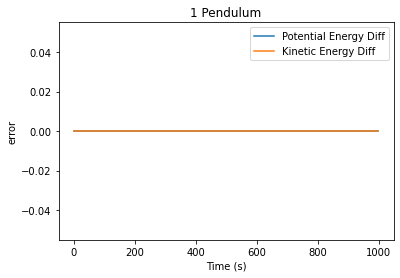

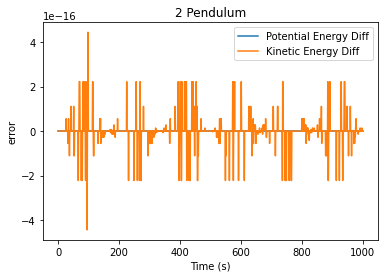

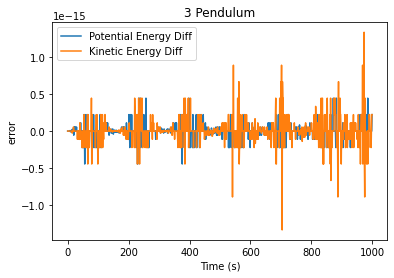

In [15]:
time = np.linspace(0, 20, 1000)
def check_and_plot_energy(n,time):
    app = n_pendulum(n,time,mass=1)
    gpe_values = app.GPE()
    ke_values = app.KE()
    theta = app.init_ode[:,:n]
    theta_dot =app.init_ode[:,n:]
    if n == 1:
        V = app.masses[0]*app.lengths[0]*np.cos(theta)
        T = .5 * app.masses[0]*np.power( app.lengths[0],2)*np.power(theta_dot,2)
    elif n ==2:
        V = app.masses[0]*app.lengths[0]*np.cos(theta[:,0])\
          +app.masses[1]*(app.lengths[1]*np.cos(theta[:,0])+app.lengths[0]*np.cos(theta[:,1]))
        T = .5 * app.masses[0]*np.power( app.lengths[0],2)*np.power(theta_dot[:,0],2) \
        + .5 * app.masses[1]*(np.power(app.lengths[0],2)*np.power(theta_dot[:,0],2)
                              +np.power(app.lengths[1],2)*np.power(theta_dot[:,1],2)
                              +2*app.lengths[0]*app.lengths[1]*theta_dot[:,0]*theta_dot[:,1]*np.cos(theta[:,0]-theta[:,1]))

#         T = .5 * app.masses[0]*np.power( app.lengths[0],2)*np.power(theta_dot[:,0],2) \
#             + .5 * app.masses[1]*(+app.lengths[0]*app.lengths[0]*theta_dot[:,0]*theta_dot[:,0]*np.cos(theta[:,0]-theta[:,0])
#                                   +app.lengths[0]*app.lengths[1]*theta_dot[:,0]*theta_dot[:,1]*np.cos(theta[:,0]-theta[:,1])
#                                   +app.lengths[1]*app.lengths[0]*theta_dot[:,1]*theta_dot[:,0]*np.cos(theta[:,1]-theta[:,0])
#                                   +app.lengths[1]*app.lengths[1]*theta_dot[:,1]*theta_dot[:,1]*np.cos(theta[:,1]-theta[:,1]))

      
    elif n ==3:
        V = app.masses[0]*app.lengths[0]*np.cos(theta[:,0])\
          + app.masses[1]*(app.lengths[0]*np.cos(theta[:,0])+app.lengths[1]*np.cos(theta[:,1]))\
          + app.masses[2]*(app.lengths[0]*np.cos(theta[:,0])+app.lengths[1]*np.cos(theta[:,1])+app.lengths[2]*np.cos(theta[:,2]))
        T = .5 * app.masses[0]*np.power( app.lengths[0],2)*np.power(theta_dot[:,0],2) \
          + .5 * app.masses[1]*(np.power(app.lengths[0],2)*np.power(theta_dot[:,0],2)
                              +np.power(app.lengths[1],2)*np.power(theta_dot[:,1],2)
                              +2*app.lengths[0]*app.lengths[1]*theta_dot[:,0]*theta_dot[:,1]*np.cos(theta[:,0]-theta[:,1]))\
          + .5 * app.masses[2]*(np.power(app.lengths[0],2)*np.power(theta_dot[:,0],2)
                              +np.power(app.lengths[1],2)*np.power(theta_dot[:,1],2)
                              +np.power(app.lengths[2],2)*np.power(theta_dot[:,2],2)
                              +2*app.lengths[0]*app.lengths[1]*theta_dot[:,0]*theta_dot[:,1]*np.cos(theta[:,0]-theta[:,1])
                              +2*app.lengths[0]*app.lengths[2]*theta_dot[:,0]*theta_dot[:,2]*np.cos(theta[:,0]-theta[:,2])
                              +2*app.lengths[1]*app.lengths[2]*theta_dot[:,1]*theta_dot[:,2]*np.cos(theta[:,1]-theta[:,2]))

    else:
        print("Enter a N value of 1-3")
        return

    if n !=1:
        gpe_values = np.sum(gpe_values,axis=1)
        ke_values=np.sum(ke_values,axis=1)
    pe_difference = np.subtract(gpe_values,-V)

    ke_difference = np.subtract(ke_values,T)
    plt.title(f"{n} Pendulum")
    plt.plot(pe_difference,label="Potential Energy Diff")

    plt.plot(ke_difference,label="Kinetic Energy Diff")
    plt.xlabel("Time (s)")
    plt.ylabel("error")
    # plt.ylim([-1E-4,1E-4])
    plt.legend()
    plt.show()

check_and_plot_energy(1,time)
check_and_plot_energy(2,time)
check_and_plot_energy(3,time)


### Verification and Analysis

To check that the GPE and KE equations being used I wrote out the equations for each by hand for a single double and triple pendilum
then I plotted the difference between the simulation and, the hard coded equations to assess the accuracy of each.
You can see the single pendulum has no errors in it, once you get to the double pendulum we see some errors in the Kinetic energy but these are in the order of 1E-16 so at the point of machine accuracy, nothing more than rounding errors.
The triple pendulum has a slightly larger range for the errors 1E-15 but still near machine percision.


In [36]:
def plot_pen(x_data,y_data,time):

    fig, ax = plt.subplots(figsize=(6, 6))

    ax.axis('off')
    ax.set(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))

    line, = ax.plot([], [], 'o-', lw=2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        line.set_data(x_data[i], y_data[i])
        return line,

    anim = animation.FuncAnimation(fig, animate, frames=len(time),
                                   interval=1000 * time[-1] / len(time),
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim









def make_plots(n,time):
    app = n_pendulum(n, time, mass=1)
    gpe_values = app.GPE()
    ke_values = app.KE()
    x_data, y_data = app.get_xy_coords()
    
    total_energy = np.sum(np.add(ke_values, gpe_values), axis=1)


    fig, ax = plt.subplots(4,  figsize=(8, 24))


    ax[0].set_title("Energy")
    ax[1].set_title("X movement over time")
    ax[2].set_title("Y movement over time")
    ax[2].set_title(f"{n}Pend")
    
    ax[0].plot(total_energy,label="Total Energy")
    ax[0].plot(np.sum(ke_values,axis=1), label="Kenetic Energy")
    ax[0].plot(np.sum(gpe_values,axis=1), label= "Potential Energy")
    ax[0].legend()
    
    ax[1].plot(time,x_data[:,1:])
    ax[2].plot(time,x_data[:,1:])
    ax[3].plot(x_data,y_data)
    plt.tight_layout()
    plt.show()
    plt.close(fig)
    
    return plot_pen(x_data,y_data,time)
    
    

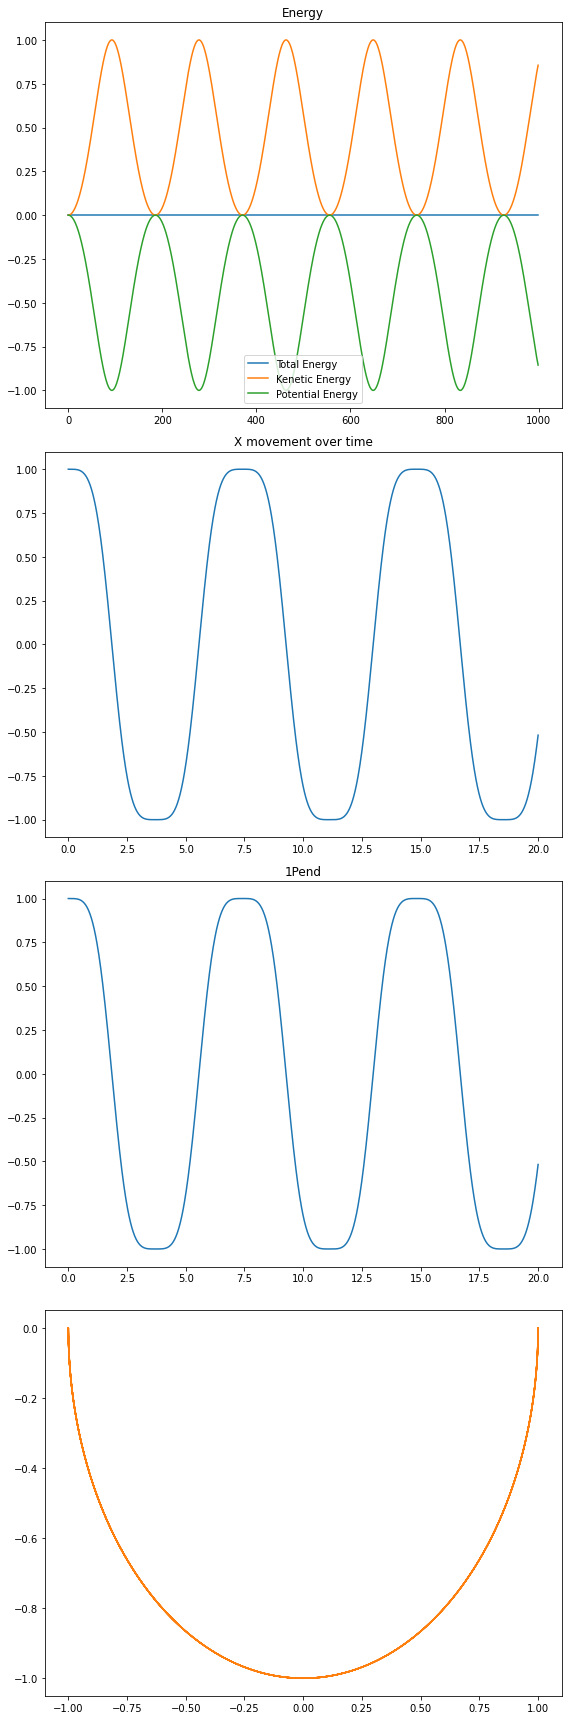

In [41]:
time = np.linspace(0, 20, 1000)

n=1
ani = make_plots(n,time)
HTML(ani.to_html5_video())

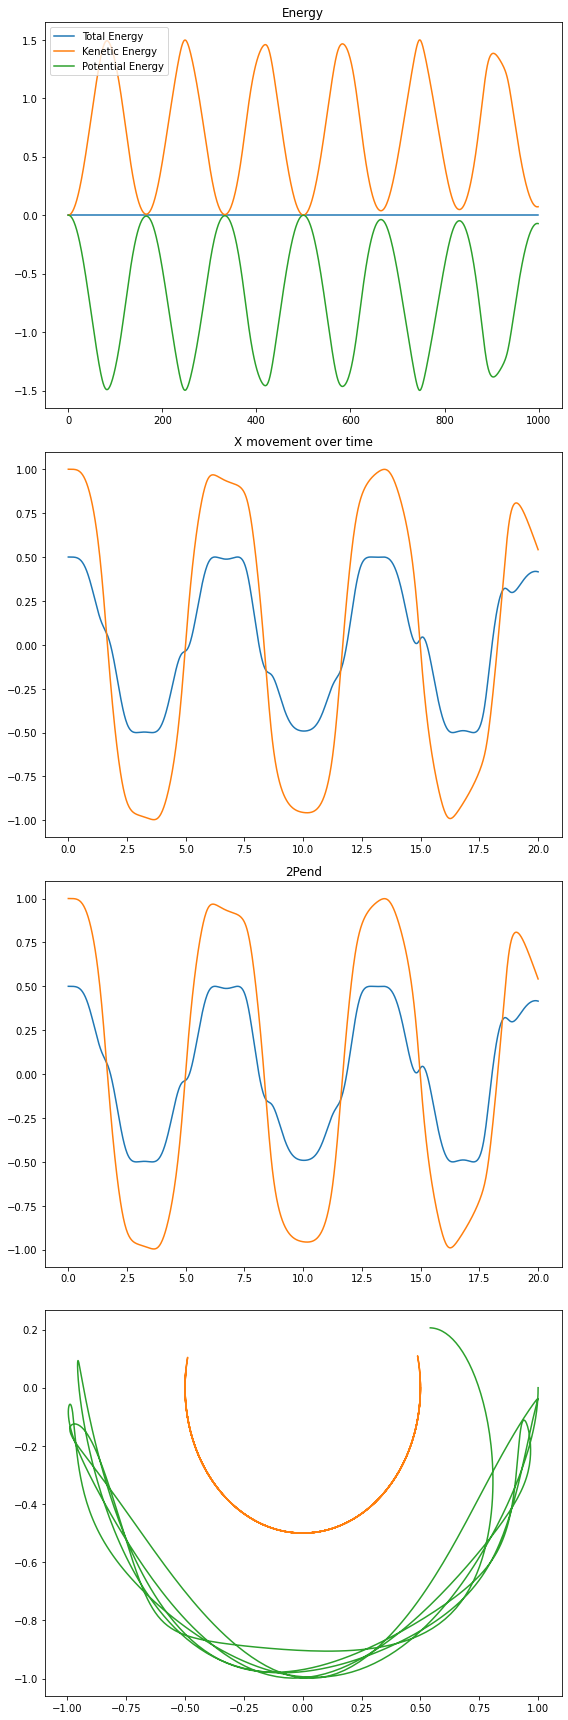

In [42]:
ani = make_plots(2,time)
HTML(ani.to_html5_video())

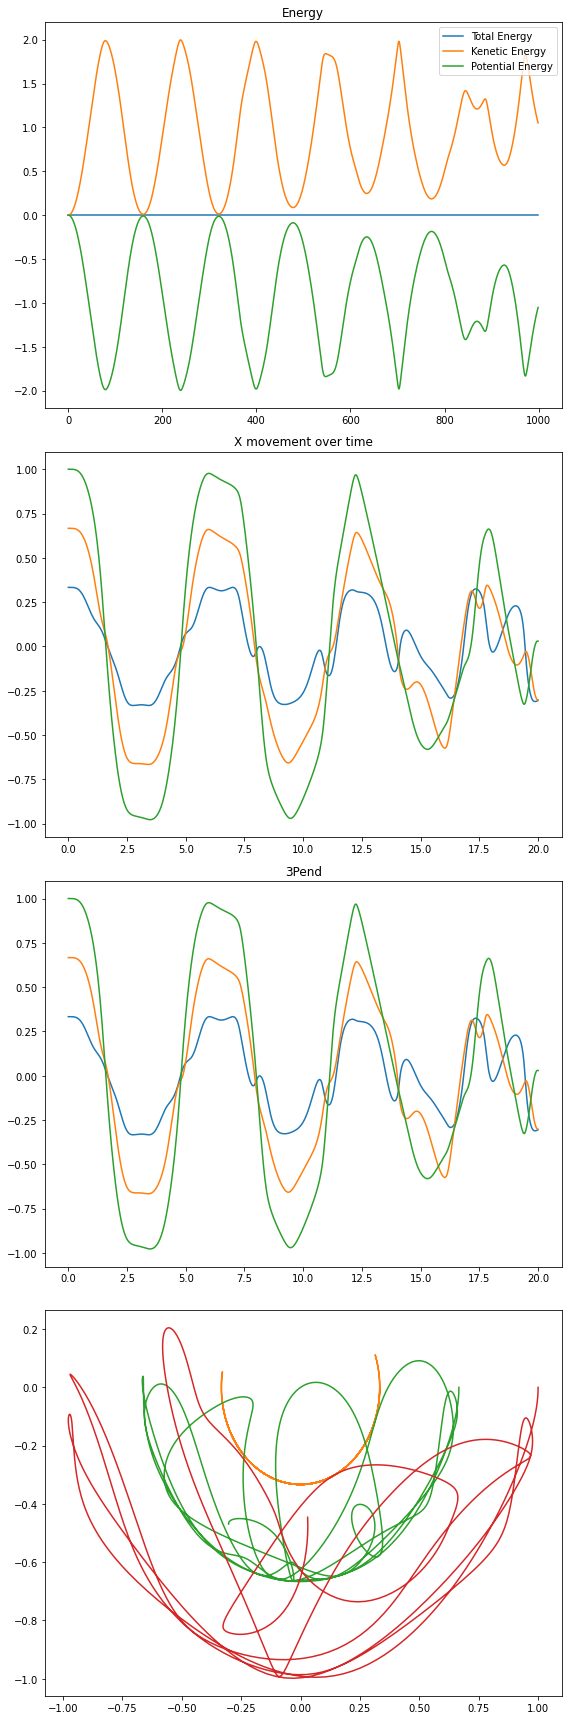

In [43]:
ani = make_plots(3,time)
HTML(ani.to_html5_video())

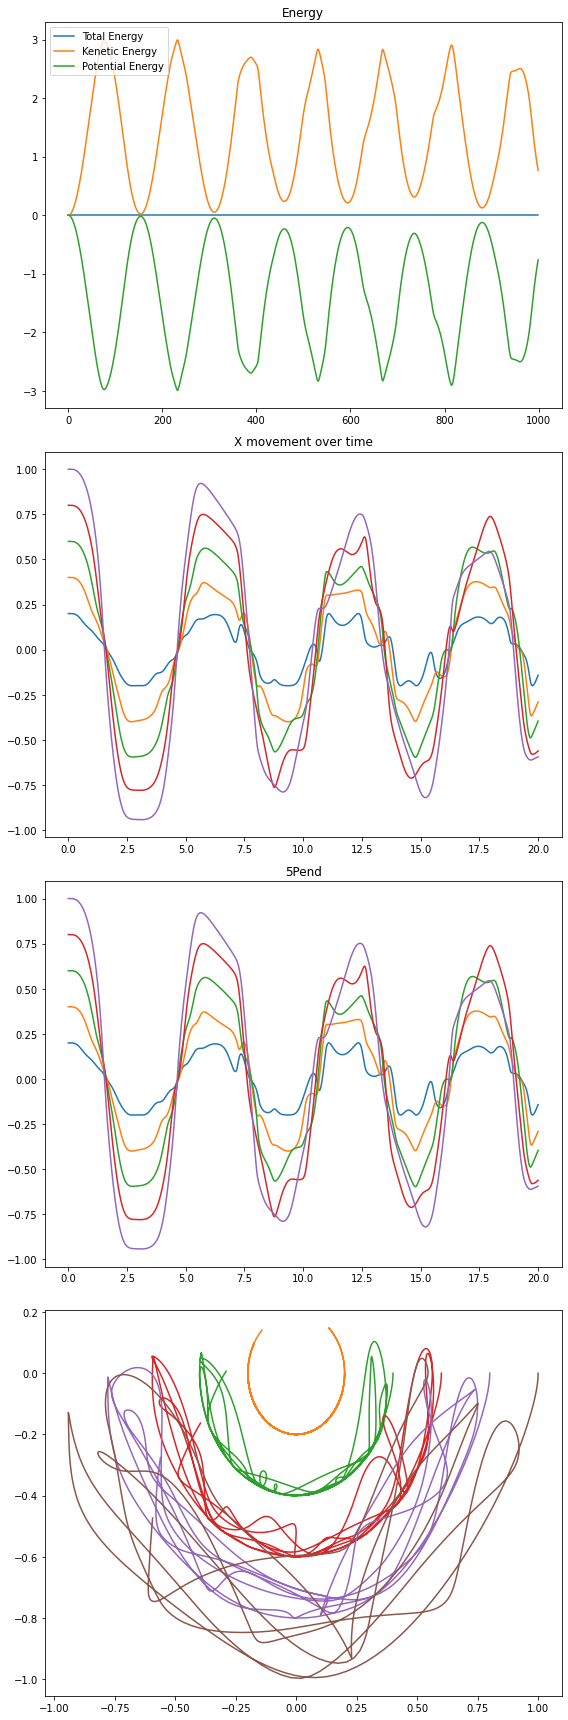

In [44]:
ani = make_plots(5,time)
HTML(ani.to_html5_video())



frame.z =  A.z
[-u0(t) + Derivative(q0(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t), -u3(t) + Derivative(q3(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t), -u3(t) + Derivative(q3(t), t), -u4(t) + Derivative(q4(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t), -u3(t) + Derivative(q3(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2

frame.z =  A.z
[-u0(t) + Derivative(q0(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t), -u3(t) + Derivative(q3(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t), -u3(t) + Derivative(q3(t), t), -u4(t) + Derivative(q4(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t), -u3(t) + Derivative(q3(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2

frame.z =  A.z
[-u0(t) + Derivative(q0(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t), -u3(t) + Derivative(q3(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t), -u3(t) + Derivative(q3(t), t), -u4(t) + Derivative(q4(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t), -u3(t) + Derivative(q3(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2

frame.z =  A.z
[-u0(t) + Derivative(q0(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t), -u3(t) + Derivative(q3(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t), -u3(t) + Derivative(q3(t), t), -u4(t) + Derivative(q4(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2(t) + Derivative(q2(t), t), -u3(t) + Derivative(q3(t), t)]
frame.z =  A.z
[-u0(t) + Derivative(q0(t), t), -u1(t) + Derivative(q1(t), t), -u2

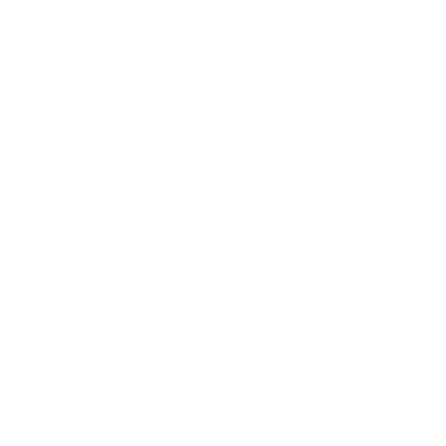

In [81]:
from IPython.display import HTML

from matplotlib import collections



def animate_pendulum_multiple(n, number_of_pendulums=20, perturbation=1E-3, track_length=15):
    oversample = 3
    track_length *= oversample

    t = np.linspace(0, 20, oversample * 200)
    p = [n_pendulum(n, t, position=3*np.pi/4 + i * perturbation / number_of_pendulums)
         for i in range(number_of_pendulums)]
    positions = np.array([pi.get_xy_coords() for pi in p])
    positions = positions.transpose(0, 2, 3, 1)
    # positions is a 4D array: (npendulums, len(t), n+1, xy)

    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))

    track_segments = np.zeros((number_of_pendulums, 0, 2))
    tracks = collections.LineCollection(track_segments, cmap='rainbow')
    tracks.set_array(np.linspace(0, 1, number_of_pendulums))
    ax.add_collection(tracks)

    points, = plt.plot([], [], 'ok')

    pendulum_segments = np.zeros((number_of_pendulums, 0, 2))
    pendulums = collections.LineCollection(pendulum_segments, colors='black')
    ax.add_collection(pendulums)

    def init():
        pendulums.set_segments(np.zeros((number_of_pendulums, 0, 2)))
        tracks.set_segments(np.zeros((number_of_pendulums, 0, 2)))
        points.set_data([], [])
        return pendulums, tracks, points

    def animate(i):
        i = i * oversample
        pendulums.set_segments(positions[:, i])
        sl = slice(max(0, i - track_length), i)
        tracks.set_segments(positions[:, sl, -1])
        x, y = positions[:, i].reshape(-1, 2).T
        points.set_data(x, y)
        return pendulums, tracks, points

    interval = 1000 * oversample * t.max() / len(t)
    anim = animation.FuncAnimation(fig, animate, frames=len(t) // oversample,
                                   interval=interval,
                                   blit=True, init_func=init)
    plt.show()
    plt.close(fig)
    return anim


anim = animate_pendulum_multiple(5,number_of_pendulums=50)
anim.save('media/Crazy_triple.mp4', extra_args=['-vcodec', 'libx264'])
HTML(anim.to_html5_video())

In [ ]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="./media/Crazy_triple.mp4"      type="video/mp4">
</video></div>""")

In [ ]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="./media/Crazy_5.mp4"      type="video/mp4">
</video></div>""")


### References
https://docs.sympy.org/latest/modules/physics/mechanics/kane.html
http://128.84.4.34/pdf/1910.12610
https://www.researchgate.net/publication/336868500_Equations_of_Motion_Formulation_of_a_Pendulum_Containing_N-point_Masses